In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from scikeras.wrappers import KerasRegressor

In [2]:
data = pd.read_csv("Data/Transformed.csv")
data

,Stocks_Apple,Stocks_GeneralElectric,Stocks_IBM,Stocks_Johnson&Johnson,Stocks_Microsoft,Date,Open,High,Low,Volume,Close
0,1,0,0,0,0,2005-07-28,0.000159,0.000116,0.000150,0.068088,0.000134
1,1,0,0,0,0,2005-07-29,0.000125,0.000161,0.000028,0.160862,0.000000
2,1,0,0,0,0,2005-08-01,0.000009,0.000009,0.000007,0.086877,0.000012
3,1,0,0,0,0,2005-08-02,0.000047,0.000058,0.000069,0.081690,0.000063
4,1,0,0,0,0,2005-08-03,0.000082,0.000036,0.000088,0.070181,0.000067
...,...,...,...,...,...,...,...,...,...,...,...
25130,0,0,0,1,0,2025-07-16,0.944729,0.976459,0.947055,0.134177,0.971310
25131,0,0,0,1,0,2025-07-17,0.965481,0.966309,0.965098,0.061532,0.958453
25132,0,0,0,1,0,2025-07-18,0.970885,0.969168,0.972749,0.051458,0.963596
25133,0,0,0,1,0,2025-07-21,0.969732,0.967881,0.968563,0.041146,0.968310


## Apple

In [22]:
df_apple = data[data["Stocks_Apple"]==1]
features = ['Stocks_Apple', 'Stocks_GeneralElectric', 'Stocks_IBM','Stocks_Johnson&Johnson', 'Stocks_Microsoft','Open', 'High','Low', 'Volume', 'Close' ]
x = list()
Y = list()
v=df_apple[features].values
for i in tqdm(range(60,len(df_apple)-180+1)):# prediction days intially 6 months(180 days)
    x.append(df_apple[features].values[i-60:i])
    Y.append(df_apple[features].values[i:i+180,9])
x = np.array(x)
Y = np.array(Y)

100%|█████████████████████████████████████████████████████████████████████████████| 4788/4788 [00:09<00:00, 498.81it/s]


In [4]:
len(data[features].columns)

10

In [4]:
#splitting 
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size=0.2,shuffle=False)
x_test_a,x_val,y_test_b,y_val = train_test_split(x_test,y_test,test_size=0.5,shuffle=False)

In [367]:
Apple_Model = Sequential([
    LSTM(216,input_shape=(60,len(data[features].columns)),activation="relu",return_sequences=True),
    Dropout(0.5),
    LSTM(128,activation="relu",return_sequences=True),
    Dropout(0.5),
    LSTM(64,activation="relu",return_sequences=False),
    Dropout(0.5),
    Dense(180,activation="linear"), #180 days (6months) pred
]);
stop = EarlyStopping(monitor="val_mae",patience=5,restore_best_weights=True,verbose=1)
Apple_Model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",metrics=["mae"])
history_apple =  Apple_Model.fit(x_train,y_train,epochs=4,batch_size=64,validation_data=(x_val,y_val),callbacks=[stop])
history_apple

Epoch 1/4


C:\Users\lipun\jupyterfix\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - loss: 0.0127 - mae: 0.0667 - val_loss: 0.0205 - val_mae: 0.1251
Epoch 2/4
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step - loss: 0.0019 - mae: 0.0255 - val_loss: 0.0091 - val_mae: 0.0764
Epoch 3/4
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - loss: 0.0014 - mae: 0.0220 - val_loss: 0.0073 - val_mae: 0.0708
Epoch 4/4
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - loss: 0.0012 - mae: 0.0202 - val_loss: 0.0195 - val_mae: 0.1287
Restoring model weights from the end of the best epoch: 3.


In [120]:
history_apple.history

{'loss': [0.014451450668275356,
  0.003877535928040743,
  0.002292523393407464,
  0.002059727208688855,
  0.001791635062545538,
  0.0015040673315525055,
  0.0014228039653971791,
  0.0013277992838993669],
 'mae': [0.07321406155824661,
  0.03619991987943649,
  0.03048713132739067,
  0.02893981710076332,
  0.02610005997121334,
  0.023268157616257668,
  0.022620346397161484,
  0.02189549431204796],
 'val_loss': [0.1107797771692276,
  0.01425771415233612,
  0.014452356845140457,
  0.014336059801280499,
  0.011607798747718334,
  0.021389296278357506,
  0.02404232881963253,
  0.017188649624586105],
 'val_mae': [0.25052860379219055,
  0.09487829357385635,
  0.100487619638443,
  0.10045162588357925,
  0.08883210271596909,
  0.1255103349685669,
  0.13471366465091705,
  0.1104661300778389]}

In [308]:
Apple_Model.evaluate(x_test,y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0072 - mae: 0.0696


[0.011633019894361496, 0.08860732614994049]

In [368]:
predict_180 = Apple_Model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [369]:
#Inversing scaled to original price!
scaled = joblib.load("Models/scaled_models/Scaled_Stocks_Apple_Close.pkl")
inverse = scaled.inverse_transform(predict_180[-1].reshape(-1,1))
inverse_y = scaled.inverse_transform(y_test[-1].reshape(-1,1))
#evaluation
error = mean_squared_error(inverse_y,inverse)
print("mse:",error)
errorabs = mean_absolute_error(inverse_y,inverse)
print("mae:",errorabs)

mse: 349.78957618193556
mae: 15.031010577237506


In [373]:
#saving
joblib.dump(Apple_Model,"Models/LSTM_models/Apple_Stock.pkl")

['Models/LSTM_models/Apple_Stock.pkl']

C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step


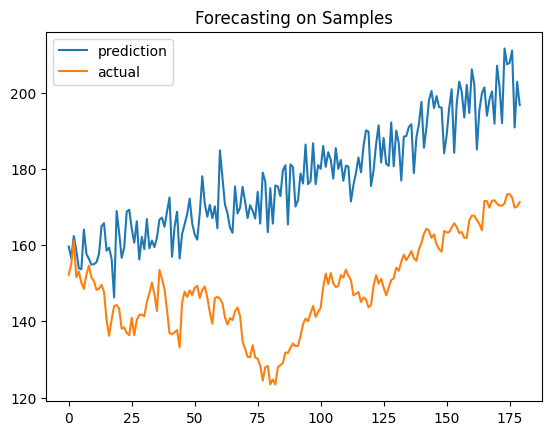

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


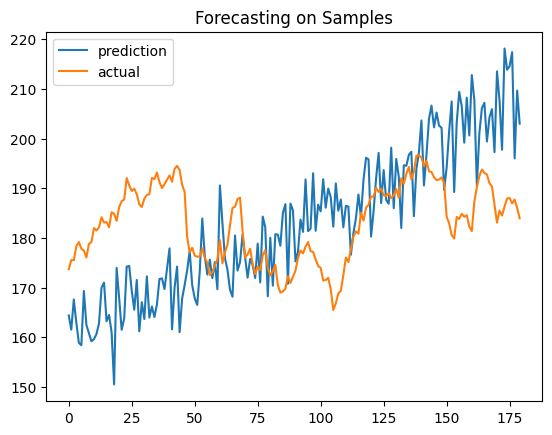

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


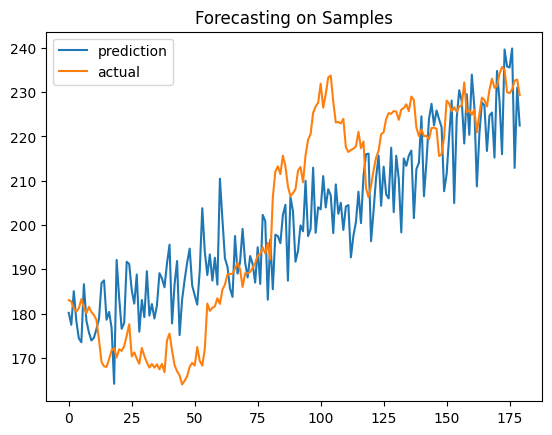

In [100]:
model = joblib.load("Models/LSTM_models/Apple_Stock.pkl")
scaled = joblib.load("Models/scaled_models/Scaled_Stocks_Apple_Close.pkl")
for i in range(-540,0,180):
    predict = model.predict(x_test)
    train_pred = model.predict(x_train)
    actual_predict = scaled.inverse_transform(predict[i].reshape(-1,1))
    actual_test = scaled.inverse_transform(y_test[i].reshape(-1,1))
    inverse_train_x = scaled.inverse_transform(train_pred[i].reshape(-1,1))
    inverse_train_y = scaled.inverse_transform(y_train[i].reshape(-1,1))
    plt.plot(actual_predict,label="prediction")
    plt.plot(actual_test,label="actual")
    plt.title("Forecasting on Samples")
    plt.legend()
    plt.show()

## Microsoft

In [104]:
# df_microsoft = data[data["Stocks_Microsoft"]==1]
x = []
Y = []
# values = df_microsoft.iloc[:,[0,1,2,3,4,6,7,8,9,10]].values
df_microsoft = pd.read_csv("msft_scaled")
df_microsoft = df_microsoft.iloc[:,2:11].values
for i in tqdm(range(60,len(df_microsoft)-180+1)):
    x.append(df_microsoft[i-60:i])
    Y.append(df_microsoft[i:i+180,4])
x = np.array(x)
Y = np.array(Y)
#splitting
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size=0.2,shuffle=False)
x_test_a,x_val,y_test_b,y_val = train_test_split(x_test,y_test,test_size=0.5,shuffle=False)
mae = 21
while(mae>20):
  Microsoft_Model = Sequential([
    LSTM(216,input_shape=(60,9),activation="relu",return_sequences=True),
    Dropout(0.4),
    LSTM(128,activation="relu",return_sequences=False),
    Dropout(0.4),
    Dense(180,activation="linear"), #180 days (6months) prei
  ]);
  stop = EarlyStopping(monitor="val_mae",patience=5,restore_best_weights=True,verbose=1)
  Microsoft_Model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",metrics=["mae"])
  Microsoft_Model_history = Microsoft_Model.fit(x_train,y_train,epochs=4,batch_size=64,validation_data=(x_val,y_val),callbacks=[stop])
  Microsoft_Model.evaluate(x_test,y_test)
  Predict = Microsoft_Model.predict(x_test)
  #Inversing to org price
  scaled_microsoft = joblib.load("Models/Scaled_Stocks_Microsoft_Close.pkl")
  inverse = scaled_microsoft.inverse_transform(Predict[-1].reshape(-1,1))
  inverse_y = scaled_microsoft.inverse_transform(y_test[-1].reshape(-1,1))
  print("mse:",mean_squared_error(inverse_y,inverse))
  print("mae:",mean_absolute_error(inverse_y,inverse))
  mae = mean_absolute_error(inverse_y,inverse)
  r2 = r2_score(inverse_y,inverse)



FileNotFoundError: [Errno 2] No such file or directory: 'msft_scaled'

In [6]:
r2

0.07239817392361958

In [8]:
joblib.dump(Microsoft_Model,"msft_stocks_moreF.pkl")

['msft_stocks_moreF.pkl']

In [38]:
Predict = Microsoft_Model.predict(x_test)
#Inversing to org price
scaled_microsoft = joblib.load("Models/Scaled_Stocks_Microsoft_Close.pkl")
inverse = scaled_microsoft.inverse_transform(Predict[-1].reshape(-1,1))
inverse_y = scaled_microsoft.inverse_transform(y_test[-1].reshape(-1,1))
print("mse:",mean_squared_error(inverse_y,inverse))
print("mae:",mean_absolute_error(inverse_y,inverse))


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
mse: 2724.536749560418
mae: 43.67722235785591


C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step


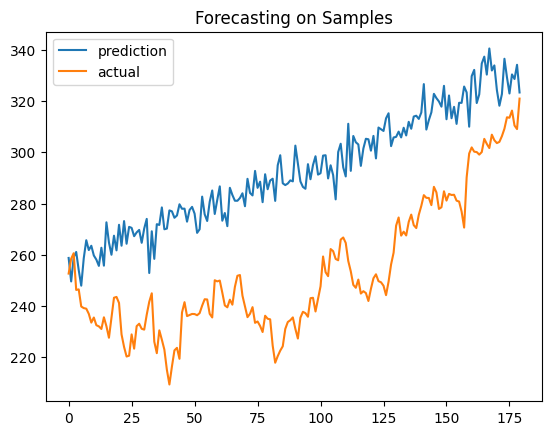

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step


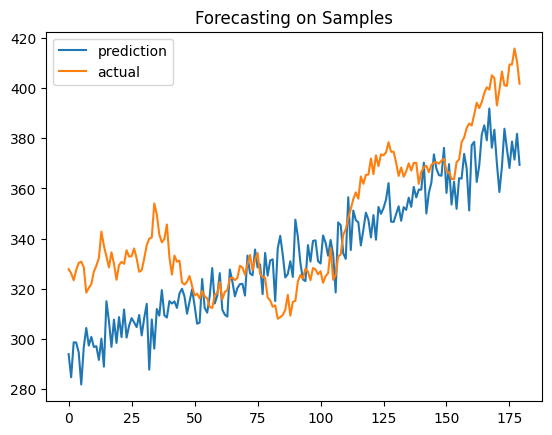

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step


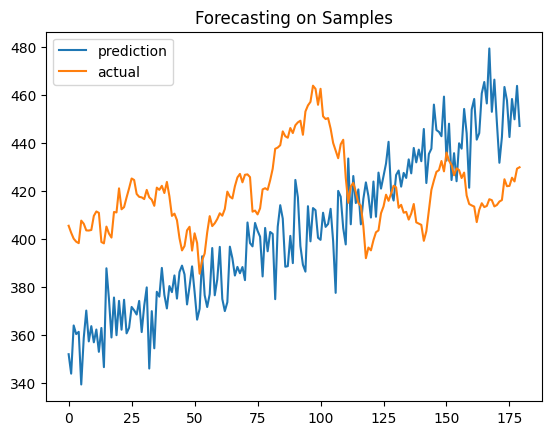

In [6]:
model = joblib.load("Models/LSTM_models/msft_stocks_moreF.pkl")
scaled = joblib.load("Models/scaled_models/scaled_Stocks_Microsoft_Close.pkl")
for i in range(-540,0,180):
    predict = model.predict(x_test)
    train_pred = model.predict(x_train)
    actual_predict = scaled.inverse_transform(predict[i].reshape(-1,1))
    actual_test = scaled.inverse_transform(y_test[i].reshape(-1,1))
    inverse_train_x = scaled.inverse_transform(train_pred[i].reshape(-1,1))
    inverse_train_y = scaled.inverse_transform(y_train[i].reshape(-1,1))
    plt.plot(actual_predict,label="prediction")
    plt.plot(actual_test,label="actual")
    plt.title("Forecasting on Samples")
    plt.legend()
    plt.show()

## IBM

In [16]:
x = []
Y = []
df_ibm = data[data["Stocks_IBM"]==1]
# df_ibm = pd.read_csv("temporary files/ibm_scaled")
df_ibm = df_ibm[features].values
# df_ibm = df_ibm.iloc[:,2:11].values
for i in tqdm(range(60,len(df_ibm)-180+1)):
    x.append(df_ibm[i-60:i])
    Y.append(df_ibm[i:i+180,9])
x = np.array(x)
Y = np.array(Y)
#splitting
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size=0.2,shuffle=False)
x_test_a,x_val,y_test_b,y_val = train_test_split(x_test,y_test,test_size=0.5,shuffle=False)
mae = 31
while mae>30:
   IBM_Model = Sequential([
      LSTM(216,input_shape=(60,10),activation="relu",return_sequences=True),
      Dropout(0.5),
      LSTM(128,activation="relu",return_sequences=False),
      Dropout(0.5),
      Dense(180,activation="linear"), #180 days (6months) prei
   ]);
   stop = EarlyStopping(monitor="val_mae",patience=5,restore_best_weights=True,verbose=1)
   IBM_Model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",metrics=["mae"])
   IBM_Model_history = IBM_Model.fit(x_train,y_train,epochs=10,batch_size=128,validation_data=(x_val,y_val),callbacks=[stop])
   IBM_Model.evaluate(x_test,y_test)
   IBM_predict = IBM_Model.predict(x_test)
   #inverse
   scaled_ibm = joblib.load("Models/scaled_models/Scaled_Stocks_IBM_Close.pkl")
   inverse = scaled_ibm.inverse_transform(IBM_predict[-1].reshape(-1,1))
   inverse_y = scaled_ibm.inverse_transform(y_test[-1].reshape(-1,1))
   print("mse:",mean_squared_error(inverse_y,inverse))
   print("mae:",mean_absolute_error(inverse_y,inverse))
   print("r2:",r2_score(inverse_y,inverse))
   mae = mean_absolute_error(inverse_y,inverse)

    

100%|█████████████████████████████████████████████████████████████████████████| 4788/4788 [00:00<00:00, 1088768.10it/s]
C:\Users\lipun\jupyterfix\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - loss: 0.0321 - mae: 0.1504 - val_loss: 0.0291 - val_mae: 0.1446
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - loss: 0.0054 - mae: 0.0568 - val_loss: 0.0387 - val_mae: 0.1648
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - loss: 0.0033 - mae: 0.0445 - val_loss: 0.0538 - val_mae: 0.1992
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - loss: 0.0027 - mae: 0.0403 - val_loss: 0.0569 - val_mae: 0.2055
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - loss: 0.0024 - mae: 0.0385 - val_loss: 0.0574 - val_mae: 0.2055
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step - loss: 0.0022 - mae: 0.0364 - val_loss: 0.0532 - val_mae: 0.1951
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0096 - mae: 0.0822
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step
mse: 1409.914565577187
mae: 30.576518927680112
r2: -1.2819525100208193
Epoch 1/10


C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\lipun\jupyterfix\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 425ms/step - loss: 0.0321 - mae: 0.1497 - val_loss: 0.0219 - val_mae: 0.1184
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - loss: 0.0054 - mae: 0.0562 - val_loss: 0.0402 - val_mae: 0.1670
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - loss: 0.0034 - mae: 0.0452 - val_loss: 0.0565 - val_mae: 0.2046
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - loss: 0.0028 - mae: 0.0408 - val_loss: 0.0520 - val_mae: 0.1923
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/step - loss: 0.0025 - mae: 0.0388 - val_loss: 0.0568 - val_mae: 0.2027
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step - loss: 0.0022 - mae: 0.0364 - val_loss: 0.0523 - val_mae: 0.1920
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0064 - mae: 0.0622
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
mse: 1396.6591059021257
mae: 29.232672119140616
r2: -1.2604984941424862


C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [42]:
# def ibm_func(units=64, dropout_rate=0.5, learning_rate=0.001):
#     IBM_Model = Sequential([
#     LSTM(units,input_shape=(60,9),activation="relu",return_sequences=True),
#     Dropout(dropout_rate),
#     LSTM(units//2,activation="relu",return_sequences=True),
#     Dropout(dropout_rate),
#     LSTM(units//4,activation="relu",return_sequences=False),
#     Dropout(dropout_rate),
#     Dense(180,activation="linear"), #180 days (6months) prei
#     ]);
#     stop = EarlyStopping(monitor="val_mae",patience=5,restore_best_weights=True,verbose=1)
#     IBM_Model.compile(optimizer=Adam(learning_rate),loss="mse",metrics=["mae"])
#     return IBM_Model
# model = KerasRegressor(build_fn=ibm_func)
# params = {
#     "model__units": [32,64,128],
#     "model__dropout_rate": [0.2, 0.3, 0.5],
#     "model__learning_rate": [0.01,0.001],
#     "batch_size": [16,32,64,128],
#     "epochs": [4,5,10]
# }
# tune = RandomizedSearchCV(estimator=model,param_distributions=params,n_iter=10,cv=5,scoring='neg_mean_absolute_error')
# tune.fit(x_train,y_train,validation_data=(x_val,y_val),callbacks=[stop])

Epoch 1/4


C:\Users\lipun\jupyterfix\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lipun\jupyterfix\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - loss: 0.0478 - mae: 0.2030 - val_loss: 0.1165 - val_mae: 0.3090
Epoch 2/4
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0123 - mae: 0.0881 - val_loss: 0.0833 - val_mae: 0.2605
Epoch 3/4
41/48 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0065 - mae: 0.0636

KeyboardInterrupt: 

In [18]:
IBM_predict = IBM_Model.predict(x_test)
#inverse
# scaled_ibm = joblib.load("Models/Scaled_Stocks_IBM_Close.pkl")
inverse = scaled_ibm.inverse_transform(IBM_predict[-1].reshape(-1,1))
inverse_y = scaled_ibm.inverse_transform(y_test[-1].reshape(-1,1))
print("mse:",mean_squared_error(inverse_y,inverse))
print("mae:",mean_absolute_error(inverse_y,inverse))
print("r2:",r2_score(inverse_y,inverse))

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
mse: 1396.6591059021257
mae: 29.232672119140616
r2: -1.2604984941424862


In [19]:
joblib.dump(IBM_Model,"Models/LSTM_models/IBM_model.pkl")

['Models/LSTM_models/IBM_model.pkl']

C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step


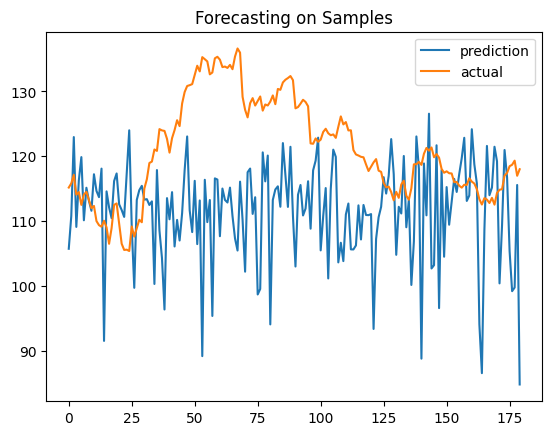

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step


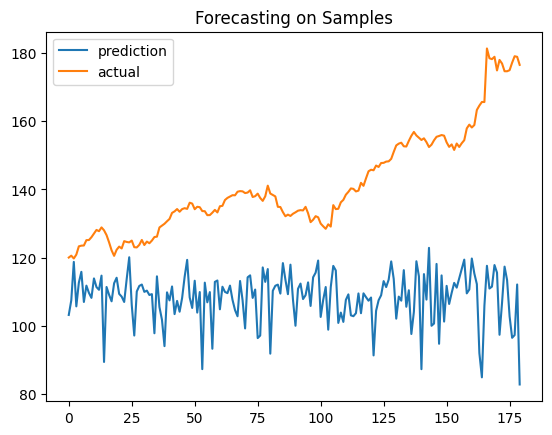

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step


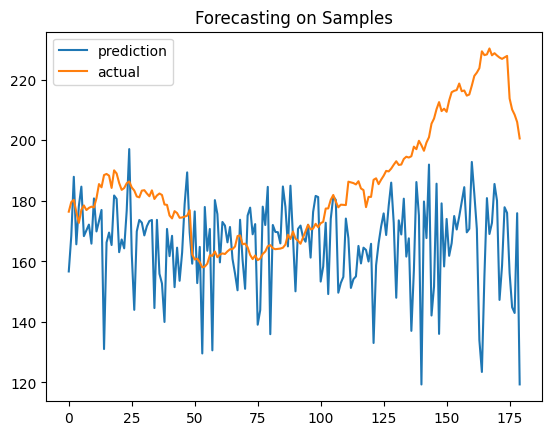

In [10]:
model = joblib.load("Models/LSTM_models/IBM_model.pkl")
scaled = joblib.load("Models/scaled_models/scaled_Stocks_IBM_Close.pkl")
for i in range(-540,0,180):
    predict = model.predict(x_test)
    train_pred = model.predict(x_train)
    actual_predict = scaled.inverse_transform(predict[i].reshape(-1,1))
    actual_test = scaled.inverse_transform(y_test[i].reshape(-1,1))
    inverse_train_x = scaled.inverse_transform(train_pred[i].reshape(-1,1))
    inverse_train_y = scaled.inverse_transform(y_train[i].reshape(-1,1))
    plt.plot(actual_predict,label="prediction")
    plt.plot(actual_test,label="actual")
    plt.title("Forecasting on Samples")
    plt.legend()
    plt.show()

## General Electric

In [36]:
df_ge = data[data["Stocks_GeneralElectric"]==1]
x = []
Y = []
values = df_ge.iloc[:,[0,1,2,3,4,6,7,8,9,10]].values
for i in tqdm(range(60,len(df_ge)-180+1)):
    x.append(values[i-60:i])
    Y.append(values[i:i+180,9])
x = np.array(x)
Y = np.array(Y)
#splitting
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size=0.2,shuffle=False)
x_test_a,x_val,y_test_b,y_val = train_test_split(x_test,y_test,test_size=0.5,shuffle=False)
GE_Model = Sequential()
GE_Model.add(LSTM(216,input_shape=(60,10),activation="relu",return_sequences=True))
GE_Model.add(Dropout(0.4))
GE_Model.add(LSTM(128,activation="relu",return_sequences=False))
GE_Model.add(Dropout(0.4))
GE_Model.add(Dense(64,activation="relu"))
GE_Model.add(Dropout(0.4))
GE_Model.add(Dense(180,activation="linear"))
stop = EarlyStopping(monitor="r2_score",patience=5,restore_best_weights=True,verbose=1)
GE_Model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",metrics=["r2_score"])
GE_Model_history = GE_Model.fit(x_train,y_train,epochs=15,batch_size=256,validation_data=(x_val,y_val),callbacks=[stop])
GE_Model.evaluate(x_test,y_test)
ge_Predict = GE_Model.predict(x_test)
#Inversing to org price
scaled_ge = joblib.load("Models/scaled_models/Scaled_Stocks_GeneralElectric_Close.pkl")
inverse = scaled_ge.inverse_transform(ge_Predict[-1].reshape(-1,1))
inverse_y = scaled_ge.inverse_transform(y_test[-1].reshape(-1,1))
print("mse:",mean_squared_error(inverse_y,inverse))
print("mae:",mean_absolute_error(inverse_y,inverse))
print("r2:",r2_score(inverse_y,inverse))

100%|██████████████████████████████████████████████████████████████████████████| 4788/4788 [00:00<00:00, 957943.50it/s]

Epoch 1/15



C:\Users\lipun\jupyterfix\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - loss: 0.0688 - r2_score: -3.5547 - val_loss: 0.1363 - val_r2_score: -3.4305
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 446ms/step - loss: 0.0368 - r2_score: -1.3840 - val_loss: 0.0531 - val_r2_score: -0.7032
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - loss: 0.0164 - r2_score: -0.0571 - val_loss: 0.0318 - val_r2_score: -0.0084
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 427ms/step - loss: 0.0105 - r2_score: 0.3070 - val_loss: 0.0427 - val_r2_score: -0.3605
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 428ms/step - loss: 0.0084 - r2_score: 0.4593 - val_loss: 0.0342 - val_r2_score: -0.0859
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 418ms/step - loss: 0.0070 - r2_score: 0.5381 - val_loss: 0.0361 - val_r2_score: -0.1452
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - loss: 0.0062 - r2_score: 0.5947 - val_loss: 0.0335 - val_r2_score: -0.0605
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - loss: 0.0061 - r2_score: 0.6036 - val_loss: 0.0299

C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [37]:
### ge_Predict = GE_Model.predict(x_test)
#Inversing to org price
scaled_ge = joblib.load("Models/scaled_models/Scaled_Stocks_GeneralElectric_Close.pkl")
inverse = scaled_ge.inverse_transform(ge_Predict[-1].reshape(-1,1))
inverse_y = scaled_ge.inverse_transform(y_test[-1].reshape(-1,1))
print("mse:",mean_squared_error(inverse_y,inverse))
print("mae:",mean_absolute_error(inverse_y,inverse))

mse: 3347.2379420242673
mae: 47.6935671488444


C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [38]:
joblib.dump(GE_Model,"Models/LSTM_models/GE_model.pkl")

['Models/LSTM_models/GE_model.pkl']

C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step


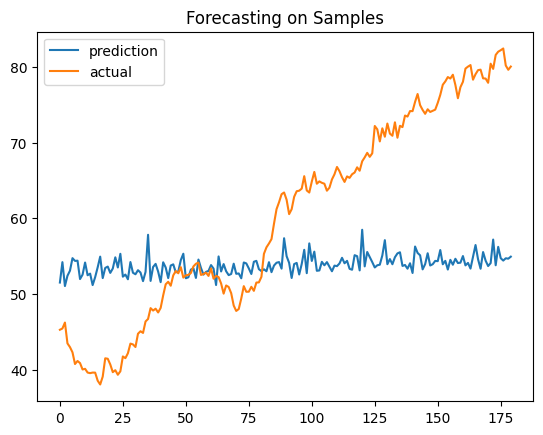

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step


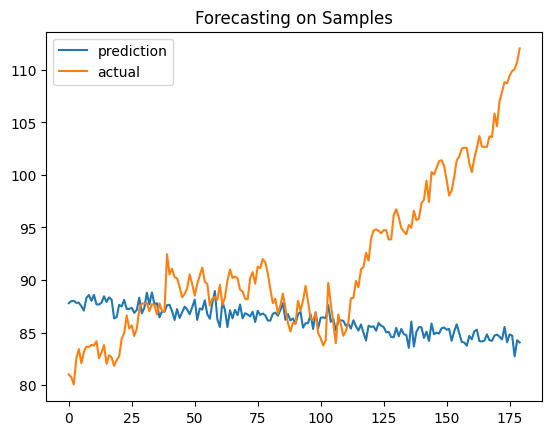

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step


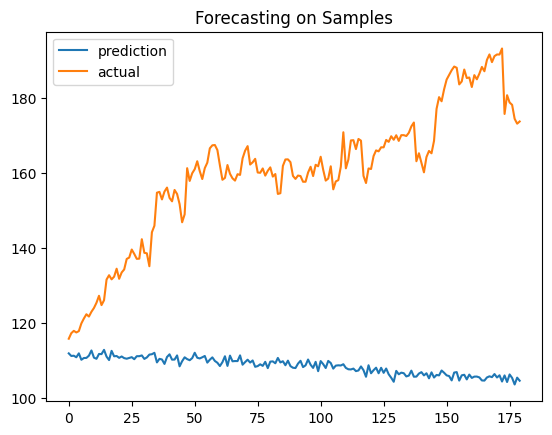

In [13]:
model = joblib.load("Models/LSTM_models/GE_model.pkl")
scaled = joblib.load("Models/scaled_models/scaled_Stocks_GeneralElectric_Close.pkl")
for i in range(-540,0,180):
    predict = model.predict(x_test)
    train_pred = model.predict(x_train)
    actual_predict = scaled.inverse_transform(predict[i].reshape(-1,1))
    actual_test = scaled.inverse_transform(y_test[i].reshape(-1,1))
    inverse_train_x = scaled.inverse_transform(train_pred[i].reshape(-1,1))
    inverse_train_y = scaled.inverse_transform(y_train[i].reshape(-1,1))
    plt.plot(actual_predict,label="prediction")
    plt.plot(actual_test,label="actual")
    plt.title("Forecasting on Samples")
    plt.legend()
    plt.show()

## JNJ

In [30]:
df_JJ = data[data["Stocks_Johnson&Johnson"]==1]
x = []
Y = []
values = df_JJ.iloc[:,[0,1,2,3,4,6,7,8,9,10]].values
for i in tqdm(range(60,len(df_JJ)-180+1)):
    x.append(values[i-60:i])
    Y.append(values[i:i+180,9])
x = np.array(x)
Y = np.array(Y)
#splitting
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size=0.2,shuffle=False)
x_test_a,x_val,y_test_b,y_val = train_test_split(x_test,y_test,test_size=0.5,shuffle=False)
JNJ_Model = Sequential()
JNJ_Model.add(LSTM(216,input_shape=(60,10),activation="relu",return_sequences=True))
JNJ_Model.add(LSTM(128,activation="relu",return_sequences=False))
JNJ_Model.add(Dense(64,activation="relu"))
JNJ_Model.add(Dense(180,activation="linear"))
stop = EarlyStopping(monitor="r2_score",patience=5,restore_best_weights=True,verbose=1)
JNJ_Model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",metrics=["r2_score"])
JNJ_Model_History = JNJ_Model.fit(x_train,y_train,epochs=15,batch_size=256,validation_data=(x_val,y_val),callbacks=[stop])
JNJ_Model.evaluate(x_test,y_test)

100%|██████████████████████████████████████████████████████████████████████████| 4788/4788 [00:00<00:00, 530885.26it/s]

Epoch 1/15



C:\Users\lipun\jupyterfix\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 478ms/step - loss: 0.1349 - r2_score: -1.4021 - val_loss: 0.4877 - val_r2_score: -231.1342
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - loss: 0.0499 - r2_score: 0.1237 - val_loss: 0.1239 - val_r2_score: -57.7197
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - loss: 0.0080 - r2_score: 0.8596 - val_loss: 0.0131 - val_r2_score: -5.3027
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 428ms/step - loss: 0.0027 - r2_score: 0.9534 - val_loss: 0.0237 - val_r2_score: -10.2356
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - loss: 0.0017 - r2_score: 0.9715 - val_loss: 0.0178 - val_r2_score: -7.4591
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 451ms/step - loss: 0.0015 - r2_score: 0.9730 - val_loss: 0.0175 - val_r2_score: -7.3232
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - loss: 0.0015 - r2_score: 0.9746 - val_loss: 0.0220 - val_r2_score: -9.4139
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - loss: 0.0015 - r2_score: 0.9741 - val_loss: 0.01

[0.007375926245003939, -2.1769213676452637]

In [64]:
jnj_Predict = JNJ_Model.predict(x_test)
#Inversing to org price
scaled_jnj = joblib.load("Models/scaled_models/Scaled_Stocks_GeneralElectric_Close.pkl")
inverse = scaled_jnj.inverse_transform(jnj_Predict[-1].reshape(-1,1))
inverse_y = scaled_jnj.inverse_transform(y_test[-1].reshape(-1,1))
print("mse:",mean_squared_error(inverse_y,inverse))
print("mae:",mean_absolute_error(inverse_y,inverse))

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
mse: 3819.379480092794
mae: 58.0589614128063


C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [32]:
joblib.dump(JNJ_Model,"Models/LSTM_models/JNJ_model.pkl")

['Models/LSTM_models/JNJ_model.pkl']

C:\Users\lipun\jupyterfix\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


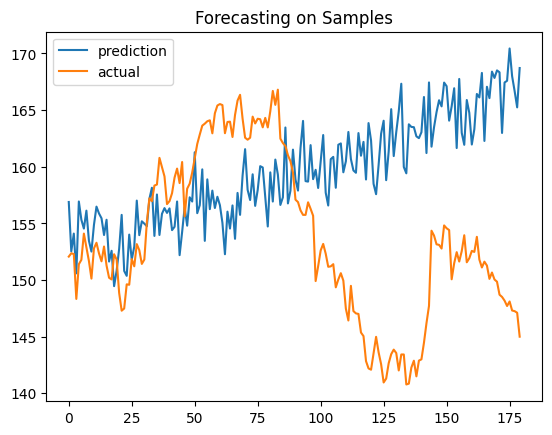

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


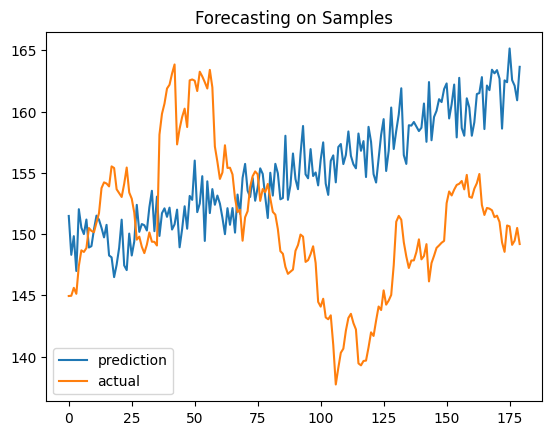

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


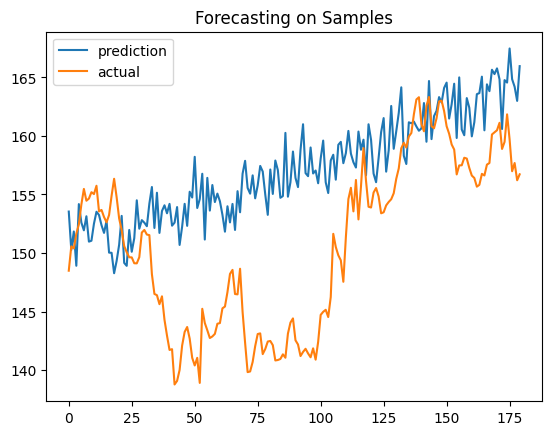

In [16]:
model = joblib.load("Models/LSTM_models/JNJ_model.pkl")
scaled = joblib.load("Models/scaled_models/scaled_Stocks_Johnson&Johnson_Close.pkl")
for i in range(-540,0,180):
    predict = model.predict(x_test)
    train_pred = model.predict(x_train)
    actual_predict = scaled.inverse_transform(predict[i].reshape(-1,1))
    actual_test = scaled.inverse_transform(y_test[i].reshape(-1,1))
    inverse_train_x = scaled.inverse_transform(train_pred[i].reshape(-1,1))
    inverse_train_y = scaled.inverse_transform(y_train[i].reshape(-1,1))
    plt.plot(actual_predict,label="prediction")
    plt.plot(actual_test,label="actual")
    plt.title("Forecasting on Samples")
    plt.legend()
    plt.show()

## FINAL REPORT: LSTM
<li>
    Most of the Stocks gives mae less than 30 and r2_score as close to 0.
</li>